## Global Temperature Predictions

This section uses global temperature data combined with global $\text{CO}_2$ concentration and warming data provided by the IPCC to compare a simple model with Global warming estimates laid out in the Special Report on Emission Scenarios(SRES).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dur_utils import colours
from numpy.lib.stride_tricks import sliding_window_view
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib as mpl
mpl.style.use('../matplotlibrc')

The global Temperature data is taken from [Berkley Earth](http://berkeleyearth.org/data/). The temperature data has missing fields as with the Global $\text{CO}_2$ data. Further, the date is formatted awkwardly into a fixed width table format with commented-out headers. Finally, the global temperature data is seasonal. Thus some data cleaning and formatting is required.

When ananlysing the data, a Fourier-based fit could be applied similarly to that performed in the section on Global $\text{CO}_2$ data. Because this section is not looking for a functional form, an average is more straightforward to implement.

After cleaning the data of null fields, a moving average can be used to remove the seasonal trends.

In [10]:
# Load, Format and clean
path = "http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_complete.txt"
colnames=['year', 'month', 'monthly_anomaly', 'monthly_anomaly_unc',
    'yearly_anomaly', 'yearly_anomaly_unc', '5yearly_anomaly',
    '5yearly_anomaly_unc', '10yearly_anomaly', '10yearly_anomaly_unc',
    '20yearly_anomaly', '20yearly_anomaly_unc'
    ]
temp_data = pd.read_fwf(path, skiprows=34, names=colnames)
temp_data['dt'] = temp_data['month']/12 + temp_data['year']
#remove the moving averages
temp_data.drop( columns=['yearly_anomaly', 'yearly_anomaly_unc',
    '5yearly_anomaly', '5yearly_anomaly_unc', '10yearly_anomaly',
    '10yearly_anomaly_unc', '20yearly_anomaly', '20yearly_anomaly_unc'],
    inplace=True
    )
# Format data 
null_sum = (temp_data.isna()).values.sum(axis=0)
path_ml =  'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv'              
co2_data = pd.read_csv(path_ml, header=0, comment='#')

pd.DataFrame(data=null_sum,
    index=temp_data.columns,
    columns=['Number of Null Values']
    )

,Number of Null Values
year,0
month,0
monthly_anomaly,1
monthly_anomaly_unc,3
dt,0


In [11]:
#Drop NA
temp_data = temp_data.dropna()
WINDOW = 120
# Sliding window weighted average:
slv = sliding_window_view(temp_data, WINDOW, 0)
time_midpoint = np.mean(slv[:,-1,:], axis=1)
win_ave_temp = slv[:,2,:]
win_ave_unc =  slv[:,3,:]

In [12]:
def  moving_ave_frame(df:pd.DataFrame, window:int)->pd.DataFrame:
    'Applies a moving average'
    slv = sliding_window_view(df, window, axis=0)
    moving_averages = np.mean(slv, axis=2)
    ma_df = pd.DataFrame(moving_averages,columns=df.keys())
    return ma_df
def  moving_std_frame(df:pd.DataFrame, window:int)->pd.DataFrame:
    'Applies a moving average'
    slv = sliding_window_view(df, window, axis=0)
    moving_averages = np.std(slv, axis=2)/np.sqrt(window)
    ma_df = pd.DataFrame(moving_averages,columns=df.keys())
    return ma_df

def lb_ub(values, sigma, factor=1):
    lb = values - sigma*factor
    ub = values + sigma*factor
    return lb, ub

def P1(x, a0, a1):
    return a0 + a1*x

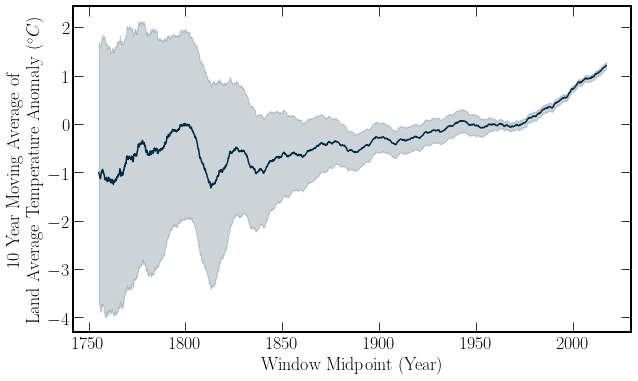

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ave_temp = np.mean(win_ave_temp,axis=1)
ave_unc = np.mean(win_ave_unc, axis=1)
lb, ub = lb_ub(ave_temp, ave_unc)
#Plotting
ax.plot(time_midpoint,
    ave_temp,
    color=colours.durham.ink
    )
ax.fill_between(time_midpoint,
    lb,
    ub,
    color = colours.durham.ink,
    alpha=0.2
    )
ax.set_xlabel('Window Midpoint (Year)')
ax.set_ylabel('10 Year Moving Average of \n \
    Land Average Temperature Anomaly $(^{\circ}C)$'
    );

## Predictions
Global temperatures provide an interesting case study for a further introduction to predictive modeling. 

There has already been substantial warming compared to the period from $1850-1900$. This period is set as a pre-industrial baseline{cite}`preindbaseline`. Further temperature rises will continue to increase the occurrence of extreme weather events and myriad other consequences, with an entire [IPCC](https://www.ipcc.ch/sr15/) report dedicated to the consequences of warming over $1.5^\circ C$. The special report on emission scenarios(SRES){cite}`SRES` produced by the IPCC in 2000, details multiple families of emission scenarios with their associated warming. 

These scenarios are developed using six independent models. Such models use economic driving forces and predict the consequences of changing macro-economic behavior, for example, the percentage of fossil fuel used compared to renewables. 

These highly detailed models are not suitable for this section. Using $\text{CO}_2$ concentration, a simple model can be formed to determine the change in temperature over the next 30 years.
The three scenarios that will be investigated are approximations of the A1 and B1 storylines described from page 247 onwards in the [SRES](https://www.ipcc.ch/site/assets/uploads/2018/03/emissions_scenarios-1.pdf).
- A1B) Continued growth in emission Rates. This scenario represents a growth-focused world with a balanced mix of energy sources. 
- A1T) Net-zero by 2030, no further reductions. This scenario corresponds to a growth-focused world with renewable energy sources.
- B1) Net-zero by 2030, and then reducing total atmospheric carbon at the same rate it is currently produced. Corresponding to a global focus on emissions reduction.
The relationship between $\text{CO}_2$ concentration used is:

```{math}
T(C) = T_0 + S \log_2(C/C_0).
```
Where $C$ is the concentration of $\text{CO}_2$ and $S$ is a fitted sensitivity factor.

## Current Warming trend 

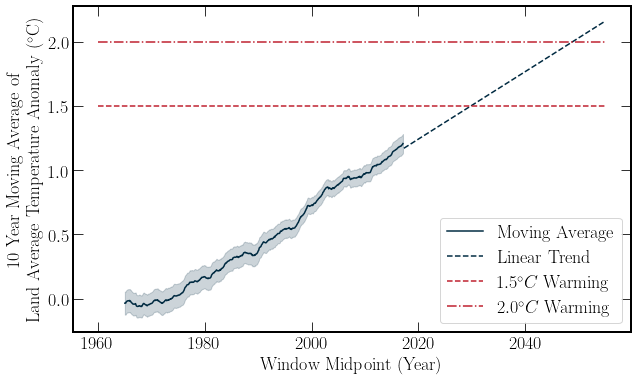

In [14]:
trend_data = temp_data[temp_data['dt'] > 1960]
trend_ave = moving_ave_frame(trend_data,WINDOW)
lb, ub = lb_ub(trend_ave['monthly_anomaly'],
    trend_ave['monthly_anomaly_unc']
    )
trend_ave.to_csv(f'../output_files/temperature_{int(WINDOW/12)}'\
    '_moving_average.csv'
    )      
trend_fit, trend_error = curve_fit(P1, trend_ave['dt'],
    trend_ave['monthly_anomaly'],
    sigma=trend_ave['monthly_anomaly_unc']
    )
gradient_lb, gradient_ub = lb_ub(trend_fit[1], trend_error[1,1]) 
lb, ub = lb_ub(trend_ave['monthly_anomaly'],
    trend_ave['monthly_anomaly_unc']
    )
#Plotting
fig, ax = plt.subplots(1,1, figsize=(10, 6))
time = np.linspace(2017.3, 2055, 300)
plt.fill_between(trend_ave['dt'], lb, ub, alpha=0.2,
    color=colours.durham.ink)
plt.plot(trend_ave['dt'],  trend_ave['monthly_anomaly'],
    c=colours.durham.ink,
    label='Moving Average')
plt.plot(time, P1(time, *trend_fit),
    linestyle='--',
    color=colours.durham.ink,
    label='Linear Trend')
ax.set_xlabel('Window Midpoint (Year)')
ax.set_ylabel(f'{int(WINDOW / 12)} Year Moving Average of \n' \
    r'Land Average Temperature Anomaly $(^{\circ}\textrm{{C}})$'
    )
#Warming Targets
x = np.linspace(1960,2055,100)
y = np.ones_like(x)
plt.plot(x, y*1.5, color=colours.durham.red,
    label='$1.5^\circ C$ Warming',
    linestyle='--'
    )
plt.plot(x, y*2, color=colours.durham.red,
    label='$2.0^\circ C$ Warming',
    linestyle='-.'
    )
plt.legend();

With a simple linear extrapolation of the Berkeley Earth temperature data, one can see that if the current rate of warming persists, then keeping the Global Temperature anomaly below $1.5^\circ C$ is unlikely, moving into the future. However, this simple model is just for getting a feeling of the data. By combining this dataset with the Global $\text{CO}_2$ data, the correlation of these datasets can be examined.  Both of the datasets' moving averages are plotted below for a visual comparison. Further, the Pearson correlation co-efficient $(r)$ can be calculated for the datasets. $r$ is given by,
```{math}
r(x,y) = \frac{\sum (x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum (x_i-\bar{x})^2 \sum (y_i-\bar{y})^2 }}.
```
Where $\bar{q}$ indicates the mean of $q$. The $r$ value can be calculated for the global $\text{CO}_2$ concentration and the temperature by taking both variables evaluated simultaneously in time. 

```{note}
The error bars on the $\text{CO_2}$ concentration are two times the standard error on the mean. However, the error bars on the temperature is the mean of the uncertainty over the window. This is because the uncertainty corresponds to 95\% of recorded percentages.  
```

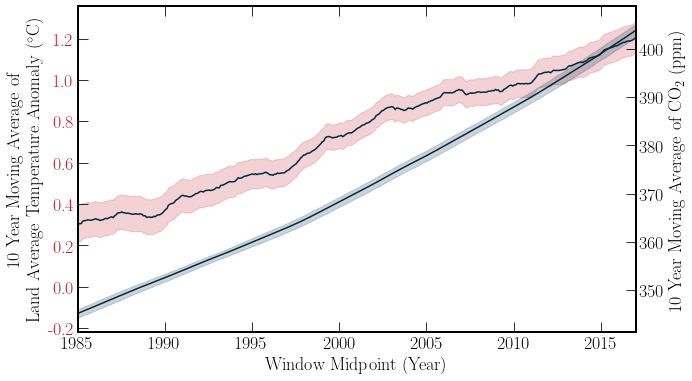

In [16]:
trend_co2_data = co2_data[co2_data['decimal'] > 1960]
trend_co2_ave = moving_ave_frame(co2_data, WINDOW)
trend_co2_std = moving_std_frame(co2_data, WINDOW)
co2_lb, co2_ub = lb_ub(trend_co2_ave['average'], trend_co2_std['average'], factor=2)
trend_co2_ave.to_csv(f'../output_files/co2_{int(WINDOW/12)}'\
    '_moving_average.csv'
    )
trend_co2_std.to_csv(f'../output_files/co2_{int(WINDOW/12)}'\
    '_moving_std.csv'
    )   
fig, ax = plt.subplots(1, 1,figsize=(10, 6))
#Temp
ax1 = ax.twinx()
ax.plot(trend_ave['dt'],  trend_ave['monthly_anomaly'],
    c=colours.durham.ink,
    label='Moving Average'
    )
ax.fill_between(trend_ave['dt'], lb, ub, alpha=0.2,
    color=colours.durham.red
    )

ax.set_ylabel(f'{int(WINDOW / 12)} Year Moving Average of \n' \
    r'Land Average Temperature Anomaly $(^{\circ}\textrm{{C}})$')
ax.set_yticks(np.arange(-.2,1.4, .2), np.round(np.arange(-.2,1.4, .2), 2),
    color=colours.durham.red
    )
ax.set_xlabel('Window Midpoint (Year)')
#CO2
ax1.plot(trend_co2_ave['decimal'],
    trend_co2_ave['average'],
    color=colours.durham.ink
    )
ax1.fill_between(trend_co2_ave['decimal'], co2_lb, co2_ub,
    alpha=0.2,
    color=colours.durham.ink
    )
ax1.set_ylabel(rf'{int(WINDOW / 12)} Year Moving Average of'  \
    r' $\textrm{{CO}}_2$ (ppm)'
    )

plt.xlim(1985, 2017);

In [ ]:
co2_slice = np.where((1985 < trend_co2_ave['decimal']) & \
    (trend_co2_ave['decimal'] < 2016)
    )
temp_slice = np.where((1985 < trend_ave['dt']) & \
    (trend_ave['dt'] < 2016)
    )
bound_co2 = trend_co2_ave['average'].iloc[co2_slice]
bound_temp = trend_ave['monthly_anomaly'].iloc[temp_slice]
r_coef = stats.pearsonr(bound_co2,np.array(bound_temp)[1:])
print(f'Pearson Correlation Coefficient:{r_coef[0]:.2}');

Pearson Correlation Coefficient:0.99


As expected the two quantities are very strongly correlated. The Pearson correlation coefficient in this scenario is not particularly useful. The information it provides is redundant with the above graph. However, with high dimensional data, a correlation matrix can glean insight into the relationship of variables. A short medium article on correlation matrix plots can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)